In [47]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Contents

* [Executive Summary](#Executive-Summary)
* [Base Model (Without SAE)](#Base-Model)
* [High Frequency (Without SAE)](#High-Frequency)

# Executive Summary

The original Spiral 3 architecutre parameters were picked as:
- **epoch = 8** (Any higher value leads to overfitting)
- **batch_size = 1000** (This gives the highest accuracy for computation speed) 

Spiral 3 used 1 layer to replicate a linear model. On Spiral 4, additional layers are addded to increase model complexity. This is based on the Learning curve calculated in Spiral 1, indicating that increasing model complexity will improve our initial Spiral 1 model of high bias.

The test score of each model is given below using 5 fold CV:

| Additonal Layers | Base | High Frequency |
|------|------|------|
|   0  | 59.31% | 73.65% |
|   1  | 59.99% | 73.62% |
|   <font color='red'>2</font>  | <font color='red'>60.24%</font> | <font color='red'>73.83%</font> |
| <font color='red'>10</font> | <font color='red'>59.76%</font> | <font color='red'>73.60%</font> |

<font color='red'>**OVERFIT</font>

Overfitting starts occuring when we have 2 additonal layers. Even having 1 additional layer did not improve our model significantly. 

Hence, sticking to just 1 layer is the optimal in terms of memory and classification.

# Without SAE

In [1]:
import sys, os, random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras.backend.tensorflow_backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
%matplotlib inline

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## Prepare fc1000 engineered images

In [2]:
root = "~/WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/"

image_features = pd.read_csv(root+"WIFIRE_fc1000_engineered_features.csv",  delimiter=',', header=None)
df = pd.read_csv(root+'WIFIRE_labels.csv')
labels = df.Labels.values

In [3]:
image_features = normalize(image_features.values) #convert df to np array

In [4]:
np.shape(image_features)

(437153, 1000)

## Configurations

In [78]:
additional_layers = 10

## Base Model (Without SAE)

Prepare image features and labels for modelling

In [79]:
X = image_features
Y = labels

In [80]:
#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
#Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=0)

The following function creates and compiles the NN architecture on the GPU

In [82]:
def baseline_model(device = 1):
    #Shut down tensorflow after use
    with K.tf.device('/gpu:'+str(device)):
        #Create model
        model = Sequential()
        model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1], 
                        kernel_initializer='normal', activation='relu'))
        for i in range(additional_layers):
            model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1],
                       kernel_initializer='normal', activation='relu'))
        model.add(Dense(len(np.unique(Y)), 
                        kernel_initializer='normal', activation='sigmoid'))
        
        #Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
        return model

KerasClassifier is an sklearn wrapper for our baseline_model

In [83]:
kc = KerasClassifier(build_fn=baseline_model, 
                            epochs=1, batch_size=1000, verbose=2)

parameters =  {'epochs':(8,)}
        
               
classifier = GridSearchCV(kc, parameters, cv=5)
classifier.fit(X_train, y_train)

Epoch 1/8
14s - loss: 1.3507 - acc: 0.4640
Epoch 2/8
13s - loss: 1.1620 - acc: 0.5831
Epoch 3/8
13s - loss: 1.1340 - acc: 0.5909
Epoch 4/8
13s - loss: 1.1183 - acc: 0.5948
Epoch 5/8
13s - loss: 1.1040 - acc: 0.6000
Epoch 6/8
13s - loss: 1.0880 - acc: 0.6038
Epoch 7/8
13s - loss: 1.0760 - acc: 0.6072
Epoch 8/8
13s - loss: 1.0642 - acc: 0.6101
Epoch 1/8
14s - loss: 1.3907 - acc: 0.4106
Epoch 2/8
13s - loss: 1.1701 - acc: 0.5780
Epoch 3/8
13s - loss: 1.1402 - acc: 0.5885
Epoch 4/8
13s - loss: 1.1210 - acc: 0.5934
Epoch 5/8
13s - loss: 1.1058 - acc: 0.5991
Epoch 6/8
13s - loss: 1.0934 - acc: 0.6016
Epoch 7/8
13s - loss: 1.0773 - acc: 0.6061
Epoch 8/8
13s - loss: 1.0642 - acc: 0.6100
Epoch 1/8
14s - loss: 1.3665 - acc: 0.4515
Epoch 2/8
13s - loss: 1.1665 - acc: 0.5810
Epoch 3/8
13s - loss: 1.1378 - acc: 0.5896
Epoch 4/8
13s - loss: 1.1178 - acc: 0.5961
Epoch 5/8
13s - loss: 1.1064 - acc: 0.5987
Epoch 6/8
13s - loss: 1.0928 - acc: 0.6033
Epoch 7/8
13s - loss: 1.0780 - acc: 0.6073
Epoch 8/8
1

GridSearchCV(cv=5, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdc724195c0>,
       fit_params={}, iid=True, n_jobs=1, param_grid={'epochs': (8,)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [84]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [85]:
conf_arr = confusion_matrix(np.argmax(y_test, axis=1), predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

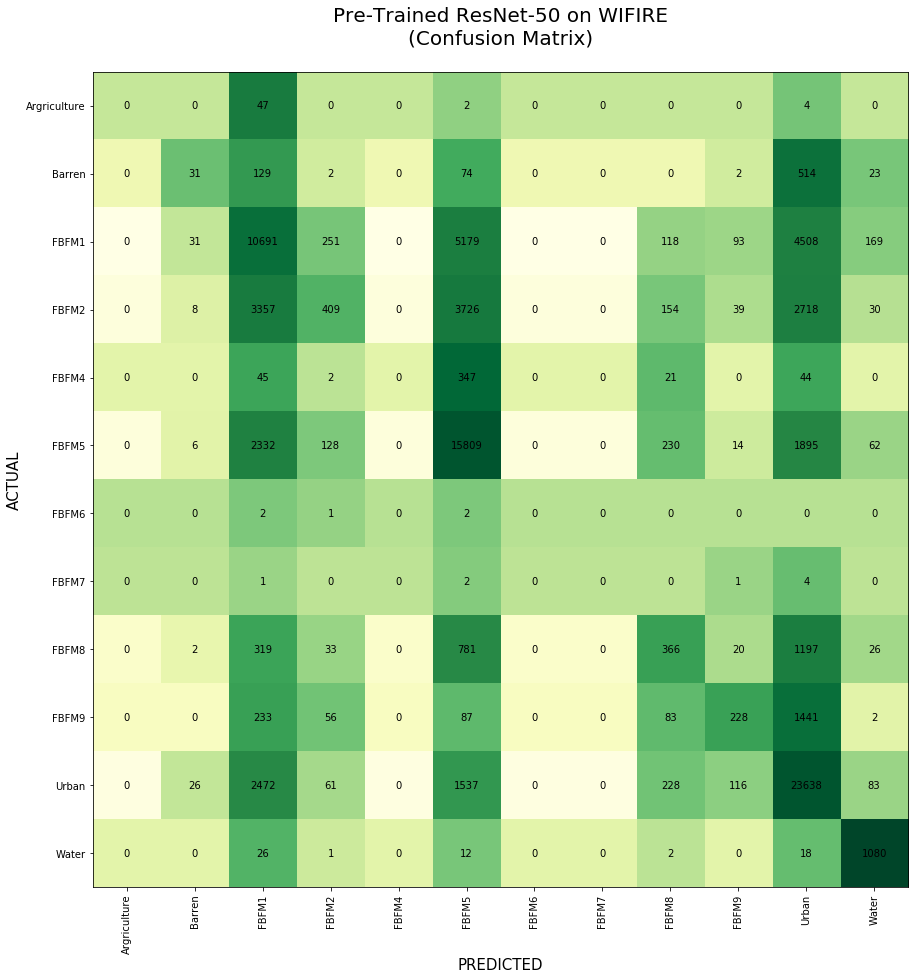

In [86]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(Y)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

In [87]:
((np.sum([np.argmax(y_test, axis=1) == predict_target])*1.0)/(len(y_test)*1.0))*100

59.763699374363789

## High Frequency (Without SAE)

Prepare image features and labels for modelling

In [88]:
high_dist_class_list = ['FBFM1','FBFM5','Urban']
df_high_class = df[df.Labels.isin(high_dist_class_list)]
high_class_idx = np.array(df_high_class.index)

In [89]:
X = image_features[high_class_idx]
Y = labels[high_class_idx]

In [90]:
#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
#Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=0)

The following function creates and compiles the NN architecture on the GPU

In [92]:
def baseline_model(device = 1):
    #Shut down tensorflow after use
    with K.tf.device('/gpu:'+str(device)):
        #Create model
        model = Sequential()
        model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1], 
                        kernel_initializer='normal', activation='relu'))
        for i in range(additional_layers):
            model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1],
                       kernel_initializer='normal',activation='relu'))
        model.add(Dense(len(np.unique(Y)), 
                        kernel_initializer='normal', activation='sigmoid'))
        
        #Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
        return model

KerasClassifier is an sklearn wrapper for our baseline_model

In [93]:
kc = KerasClassifier(build_fn=baseline_model, 
                            epochs=1, batch_size=1000, verbose=2)

parameters =  {'epochs':(8,)}
        
               
classifier = GridSearchCV(kc, parameters, cv=5)
classifier.fit(X_train, y_train)

Epoch 1/8
12s - loss: 0.7124 - acc: 0.6935
Epoch 2/8
10s - loss: 0.6605 - acc: 0.7232
Epoch 3/8
10s - loss: 0.6416 - acc: 0.7313
Epoch 4/8
10s - loss: 0.6349 - acc: 0.7341
Epoch 5/8
10s - loss: 0.6236 - acc: 0.7389
Epoch 6/8
10s - loss: 0.6130 - acc: 0.7433
Epoch 7/8
10s - loss: 0.6028 - acc: 0.7481
Epoch 8/8
10s - loss: 0.5918 - acc: 0.7531
Epoch 1/8
12s - loss: 0.7195 - acc: 0.6858
Epoch 2/8
10s - loss: 0.6605 - acc: 0.7221
Epoch 3/8
10s - loss: 0.6441 - acc: 0.7292
Epoch 4/8
10s - loss: 0.6332 - acc: 0.7347
Epoch 5/8
10s - loss: 0.6238 - acc: 0.7389
Epoch 6/8
10s - loss: 0.6146 - acc: 0.7432
Epoch 7/8
10s - loss: 0.6033 - acc: 0.7475
Epoch 8/8
10s - loss: 0.5930 - acc: 0.7515
Epoch 1/8
12s - loss: 0.7178 - acc: 0.6869
Epoch 2/8
10s - loss: 0.6578 - acc: 0.7232
Epoch 3/8
10s - loss: 0.6419 - acc: 0.7302
Epoch 4/8
10s - loss: 0.6338 - acc: 0.7346
Epoch 5/8
10s - loss: 0.6220 - acc: 0.7393
Epoch 6/8
10s - loss: 0.6121 - acc: 0.7435
Epoch 7/8
10s - loss: 0.6023 - acc: 0.7489
Epoch 8/8
1

GridSearchCV(cv=5, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdc6f4d7198>,
       fit_params={}, iid=True, n_jobs=1, param_grid={'epochs': (8,)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [94]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [95]:
conf_arr = confusion_matrix(np.argmax(y_test, axis=1), predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

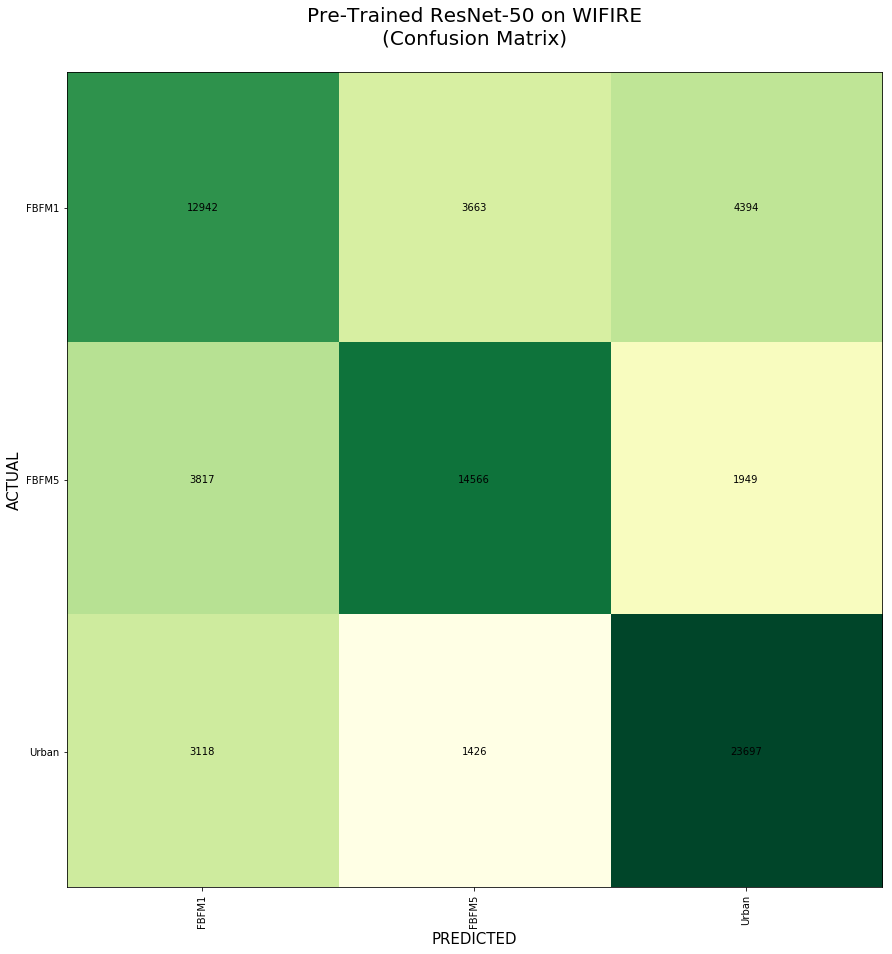

In [96]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(Y)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

In [97]:
((np.sum([np.argmax(y_test, axis=1) == predict_target])*1.0)/(len(y_test)*1.0))*100

73.600011498878857